In [113]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from math import sqrt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
df=pd.read_csv("Data/FoodBalanceSheets_E_All_Data/FoodBalanceSheets_E_All_Data_NOFLAG.csv", encoding="latin-1")

In [3]:
df.drop(["Area Code","Item Code","Element Code"],axis=1,inplace=True)
df

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
0,Afghanistan,Population,Total Population - Both sexes,1000 persons,29186.00,30117.00,31161.00,32270.00,33371.00,34414.00,35383.00,36296.00,37172.00,38042.00
1,Afghanistan,Population,Domestic supply quantity,1000 tonnes,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,Afghanistan,Grand Total,Food supply (kcal/capita/day),kcal/capita/day,2170.00,2152.00,2159.00,2196.00,2265.00,2250.00,2228.00,2303.00,2270.00,2273.00
3,Afghanistan,Grand Total,Protein supply quantity (g/capita/day),g/capita/day,59.23,58.00,57.82,57.71,60.17,58.45,58.46,59.50,57.62,57.31
4,Afghanistan,Grand Total,Fat supply quantity (g/capita/day),g/capita/day,36.69,34.81,36.53,37.10,41.48,38.28,40.70,40.03,41.46,39.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319738,Net Food Importing Developing Countries,Miscellaneous,Food,1000 tonnes,787.00,839.00,921.00,935.00,958.00,992.00,1032.00,1066.00,1140.00,1199.00
319739,Net Food Importing Developing Countries,Miscellaneous,Food supply quantity (kg/capita/yr),kg,0.62,0.65,0.68,0.67,0.67,0.68,0.69,0.70,0.73,0.75
319740,Net Food Importing Developing Countries,Miscellaneous,Food supply (kcal/capita/day),kcal/capita/day,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
319741,Net Food Importing Developing Countries,Miscellaneous,Protein supply quantity (g/capita/day),g/capita/day,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02


In [4]:
df.dropna(axis=0, inplace=True)

In [5]:
df=df.loc[~(df.iloc[:,4:]==0).all(axis=1)]

In [6]:
df.Area.value_counts()[:30]

World                                      1738
Asia                                       1659
Net Food Importing Developing Countries    1604
Americas                                   1590
Africa                                     1551
Europe                                     1531
European Union (27)                        1506
Western Asia                               1503
Low Income Food Deficit Countries          1498
Least Developed Countries                  1470
Land Locked Developing Countries           1462
Eastern Asia                               1460
South America                              1424
South-eastern Asia                         1414
Southern Europe                            1407
Central America                            1400
China                                      1395
Southern Asia                              1374
Eastern Africa                             1366
Oceania                                    1366
Small Island Developing States          

In [7]:
df.Item.value_counts()[:30]

Milk - Excluding Butter       5280
Eggs                          4586
Miscellaneous                 3556
Cereals - Excluding Beer      3243
Oilcrops                      3075
Starchy Roots                 2964
Wheat and products            2802
Fruits - Excluding Wine       2801
Maize and products            2796
Potatoes and products         2686
Rice and products             2685
Vegetables                    2648
Pulses                        2611
Vegetables, other             2596
Vegetable Oils                2582
Fruits, other                 2543
Animal fats                   2419
Meat                          2412
Fish, Seafood                 2407
Sugar & Sweeteners            2300
Pulses, Other and products    2281
Oilcrops Oil, Other           2233
Stimulants                    2226
Fats, Animals, Raw            2210
Poultry Meat                  2193
Alcoholic Beverages           2184
Barley and products           2182
Pelagic Fish                  2170
Oranges, Mandarines 

In [8]:
df.Element.unique()

array(['Total Population - Both sexes', 'Food supply (kcal/capita/day)',
       'Protein supply quantity (g/capita/day)',
       'Fat supply quantity (g/capita/day)', 'Production',
       'Import Quantity', 'Stock Variation', 'Export Quantity',
       'Domestic supply quantity', 'Feed', 'Seed', 'Losses', 'Residuals',
       'Food', 'Food supply quantity (kg/capita/yr)', 'Processing',
       'Other uses (non-food)', 'Tourist consumption'], dtype=object)

In [9]:
def select(area,item ):
    data=df[df.Area==area]
    data=data[data['Item'].str.contains(item)]
    return data

In [10]:
data=select("China","Cereals - Ex")

In [11]:
data

,Area,Item,Element,Unit,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019
44939,China,Cereals - Excluding Beer,Production,1000 tonnes,498113.00,521383.00,541368.00,554623.00,559483.00,620074.00,616491.00,616130.00,611244.00,614914.00
44940,China,Cereals - Excluding Beer,Import Quantity,1000 tonnes,13861.00,13044.00,22636.00,22952.00,28186.00,41880.00,31380.00,35473.00,29491.00,27492.00
44941,China,Cereals - Excluding Beer,Stock Variation,1000 tonnes,8114.00,16754.00,34353.00,64549.00,75918.00,80210.00,44705.00,35028.00,7514.00,6019.00
44942,China,Cereals - Excluding Beer,Export Quantity,1000 tonnes,3127.00,2793.00,2456.00,2414.00,2029.00,1770.00,2323.00,3686.00,5683.00,7154.00
44943,China,Cereals - Excluding Beer,Domestic supply quantity,1000 tonnes,500734.00,514880.00,527195.00,510613.00,509722.00,579975.00,600843.00,612889.00,627539.00,629233.00
44944,China,Cereals - Excluding Beer,Feed,1000 tonnes,151931.00,158640.00,164114.00,151419.00,146148.00,188554.00,211366.00,219363.00,231253.00,232039.00
44945,China,Cereals - Excluding Beer,Seed,1000 tonnes,13242.00,13073.00,13167.00,12518.00,13292.00,13672.00,13576.00,13449.00,13225.00,12829.00
44946,China,Cereals - Excluding Beer,Losses,1000 tonnes,19013.00,19976.00,21105.00,21453.00,21926.00,24945.00,24365.00,24293.00,24021.00,23997.00
44947,China,Cereals - Excluding Beer,Processing,1000 tonnes,11574.00,12760.00,12688.00,13384.00,16191.00,15775.00,14741.00,14499.00,12829.00,12608.00
44948,China,Cereals - Excluding Beer,Other uses (non-food),1000 tonnes,28599.00,29694.00,32682.00,30592.00,28518.00,48065.00,49183.00,50367.00,52781.00,52100.00


In [12]:
def mean_based(year):
    try:
        mean_pred=[]
        losses=data[data.Element=="Losses"].iloc[0,4:]
        count=0
        sum=0
        for i in losses.index:
            if i=="Y"+str(year):
                break
            sum=losses[i]+sum
            count+=1
        mean_pred=sum/count
        return mean_pred
    except:
        return losses["Y"+str(year)]

In [13]:
predd=mean_based(2005)
predd

22509.4

In [14]:
mean_based_pred=[]
losses=pd.DataFrame(data[data.Element=="Losses"].iloc[0,4:])
losses.columns=["Actual"]
losses["MeanBasedPred"]=np.zeros([len(losses)])
for i in losses.index:
    losses["MeanBasedPred"][i]=mean_based(int(i[1:]))

/var/folders/t6/nkv95bj97gv9j73w9bfk2p0r0000gn/T/ipykernel_25222/3604102451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  losses["MeanBasedPred"][i]=mean_based(int(i[1:]))


In [15]:
losses.reset_index()

,index,Actual,MeanBasedPred
0,Y2010,19013.0,19013.000000
1,Y2011,19976.0,19013.000000
2,Y2012,21105.0,19494.500000
3,Y2013,21453.0,20031.333333
4,Y2014,21926.0,20386.750000
5,Y2015,24945.0,20694.600000
6,Y2016,24365.0,21403.000000
7,Y2017,24293.0,21826.142857
8,Y2018,24021.0,22134.500000
9,Y2019,23997.0,22344.111111


In [16]:
losses["Actual"]

Y2010    19013.0
Y2011    19976.0
Y2012    21105.0
Y2013    21453.0
Y2014    21926.0
Y2015    24945.0
Y2016    24365.0
Y2017    24293.0
Y2018    24021.0
Y2019    23997.0
Name: Actual, dtype: object

In [17]:
import math
MSE = np.square(np.subtract(losses["Actual"].values,losses["MeanBasedPred"].values)).mean() 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

2170.879042597463


In [18]:
int(losses.index[0][1:])

2010

In [19]:
losses["Actual"]["Y2010"]

19013.0

In [20]:
losses

,Actual,MeanBasedPred
Y2010,19013.0,19013.000000
Y2011,19976.0,19013.000000
Y2012,21105.0,19494.500000
Y2013,21453.0,20031.333333
Y2014,21926.0,20386.750000
Y2015,24945.0,20694.600000
Y2016,24365.0,21403.000000
Y2017,24293.0,21826.142857
Y2018,24021.0,22134.500000
Y2019,23997.0,22344.111111


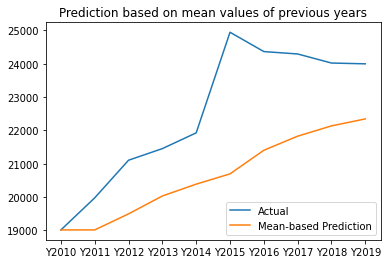

In [21]:
plt.plot(losses.index,losses["Actual"])
plt.plot(losses.index,losses.MeanBasedPred)
plt.title("Prediction based on mean values of previous years")
plt.legend(['Actual', 'Mean-based Prediction'], loc='lower right')

In [22]:
population=df[df["Element"]=="Total Population - Both sexes"]
population=population[population.Area=="China"].iloc[0,4:]*1000
population

Y2010    1399503000.0
Y2011    1407325000.0
Y2012    1415164000.0
Y2013    1422971000.0
Y2014    1430671000.0
Y2015    1438193000.0
Y2016    1445524000.0
Y2017    1452626000.0
Y2018    1459378000.0
Y2019    1465634000.0
Name: 44928, dtype: object

In [23]:
lstm_data=pd.DataFrame(population)
lstm_data.columns=["Population"]

In [24]:
lstm_data["Actual Loss"]=losses["Actual"]

In [25]:
lstm_data.to_csv("lstm_data.csv")

# LSTM MODEL

In [26]:
lstm_data

,Population,Actual Loss
Y2010,1399503000.0,19013.0
Y2011,1407325000.0,19976.0
Y2012,1415164000.0,21105.0
Y2013,1422971000.0,21453.0
Y2014,1430671000.0,21926.0
Y2015,1438193000.0,24945.0
Y2016,1445524000.0,24365.0
Y2017,1452626000.0,24293.0
Y2018,1459378000.0,24021.0
Y2019,1465634000.0,23997.0


ARIMA MODEL

In [29]:

from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot

# # fit model
# model = ARIMA(lstm_data["Actual Loss"], order=(1,1,0))
# model_fit = model.fit()
# # summary of fit model
# print(model_fit.summary())
# # line plot of residuals
# residuals = DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()
# # density plot of residuals
# residuals.plot(kind='kde')
# pyplot.show()
# # summary stats of residuals
# print(residuals.describe())

/var/folders/t6/nkv95bj97gv9j73w9bfk2p0r0000gn/T/ipykernel_25222/2612410430.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


predicted=25240.417369, expected=24365.000000
predicted=24320.932937, expected=24293.000000
predicted=24287.198562, expected=24021.000000
predicted=23997.888237, expected=23997.000000
Test RMSE: 457.711


/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


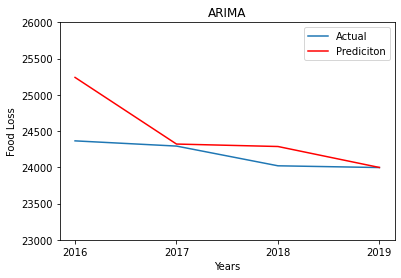

In [30]:

series=lstm_data["Actual Loss"]
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
years=['2016','2017','2018','2019']
pyplot.plot(years,test)
pyplot.plot(predictions, color='red')
pyplot.xlabel("Years")
pyplot.ylabel("Food Loss")
plt.legend(["Actual","Prediciton"])
plt.title("ARIMA")
plt.ylim(23000,26000)
pyplot.show()


In [31]:
predictions

[25240.417368872564, 24320.93293662449, 24287.198561513767, 23997.888236644696]

In [32]:
# df_for_training=lstm_data[:-3].to_numpy()
# df_for_testing=lstm_data[-3:].to_numpy()

In [33]:
def df_to_X_y(df, window_size=3):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [102]:
WINDOW_SIZE = 3
X1, y1 = df_to_X_y(lstm_data["Actual Loss"], WINDOW_SIZE)
X1.shape, y1.shape

((7, 3, 1), (7,))

In [103]:
X_train1, y_train1 = X1[:4], y1[:4]
X_val1, y_val1 = X1[4:6], y1[4:6]
X_test1, y_test1 = X1[6:], y1[6:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4, 3, 1), (4,), (2, 3, 1), (2,), (1, 3, 1), (1,))

In [104]:
from sklearn.preprocessing import StandardScaler


scalers = {}
for i in range(X_train1.shape[1]):
    scalers[i] = StandardScaler()
    X_train1[:, i, :] = scalers[i].fit_transform(X_train1[:, i, :]) 

for i in range(X_test1.shape[1]):
    X_test1[:, i, :] = scalers[i].transform(X_test1[:, i, :]) 

In [67]:
model1 = Sequential()
model1.add(InputLayer((3, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

# model1.summary()

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 539233280.0000 - root_mean_squared_error: 23221.3965

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 5s 5s/step - loss: 539233280.0000 - root_mean_squared_error: 23221.3965 - val_loss: 368912032.0000 - val_root_mean_squared_error: 19207.0820
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 334304448.0000 - root_mean_squared_error: 18283.9941

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 334304448.0000 - root_mean_squared_error: 18283.9941 - val_loss: 82948400.0000 - val_root_mean_squared_error: 9107.6016
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 68232768.0000 - root_mean_squared_error: 8260.3125

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 68232768.0000 - root_mean_squared_error: 8260.3125 - val_loss: 77536200.0000 - val_root_mean_squared_error: 8805.4639
Epoch 4/20
1/1 [==============================] - 0s 22ms/step - loss: 98096296.0000 - root_mean_squared_error: 9904.3574 - val_loss: 98238832.0000 - val_root_mean_squared_error: 9911.5508
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 120977584.0000 - root_mean_squared_error: 10998.9814

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 120977584.0000 - root_mean_squared_error: 10998.9814 - val_loss: 5064732.0000 - val_root_mean_squared_error: 2250.4958
Epoch 6/20
1/1 [==============================] - 0s 23ms/step - loss: 12708782.0000 - root_mean_squared_error: 3564.9380 - val_loss: 26743740.0000 - val_root_mean_squared_error: 5171.4351
Epoch 7/20
1/1 [==============================] - 0s 23ms/step - loss: 19781922.0000 - root_mean_squared_error: 4447.6875 - val_loss: 82448880.0000 - val_root_mean_squared_error: 9080.1367
Epoch 8/20
1/1 [==============================] - 0s 23ms/step - loss: 67787360.0000 - root_mean_squared_error: 8233.3076 - val_loss: 94378352.0000 - val_root_mean_squared_error: 9714.8525
Epoch 9/20
1/1 [==============================] - 0s 23ms/step - loss: 78466632.0000 - root_mean_squared_error: 8858.1396 - val_loss: 60720688.0000 - val_root_mean_squared_error: 7792.3481
Epoch 10/20
1/1 [==============================] - 0s 23ms/step - l

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1/1 [==============================] - 3s 3s/step - loss: 10309953.0000 - root_mean_squared_error: 3210.9116 - val_loss: 1535935.0000 - val_root_mean_squared_error: 1239.3285
Epoch 12/20
1/1 [==============================] - 0s 22ms/step - loss: 7181851.5000 - root_mean_squared_error: 2679.8977 - val_loss: 26336720.0000 - val_root_mean_squared_error: 5131.9316
Epoch 13/20
1/1 [==============================] - 0s 22ms/step - loss: 39660308.0000 - root_mean_squared_error: 6297.6431 - val_loss: 30555044.0000 - val_root_mean_squared_error: 5527.6616
Epoch 14/20
1/1 [==============================] - 0s 23ms/step - loss: 44658276.0000 - root_mean_squared_error: 6682.6846 - val_loss: 7378102.0000 - val_root_mean_squared_error: 2716.2661
Epoch 15/20
1/1 [==============================] - 0s 22ms/step - loss: 15940850.0000 - root_mean_squared_error: 3992.5994 - val_loss: 1539218.5000 - val_root_mean_squared_error: 1240.6525
Epoch 16/20
1/1 [==============================] - 0s 22ms/step - lo

In [494]:


# parameters = {'learning_rate':(0.001,0.01,0.1,1,10,100), 'optimizer':('Adam')}
# model1_params = GridSearchCV(model1, parameters)
# model1_params.fit(X_train1, y_train1,scoring=accuracy)

In [68]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [69]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

1/1 [==============================] - 0s 365ms/step


,Train Predictions,Actuals
0,25388.84375,21453.0
1,25388.84375,21926.0
2,25388.84375,24945.0
3,25388.84375,24365.0


In [70]:
mean_absolute_error(y_train1,train_predictions)

2216.59375

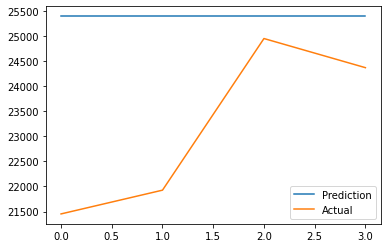

In [71]:
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='lower right')

In [72]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

1/1 [==============================] - 0s 15ms/step


,Val Predictions,Actuals
0,25388.84375,24293.0
1,25388.84375,24021.0


In [73]:
# plt.plot(val_results['Val Predictions'])
# plt.plot(val_results['Actuals'])

In [74]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,25388.84375,23997.0


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


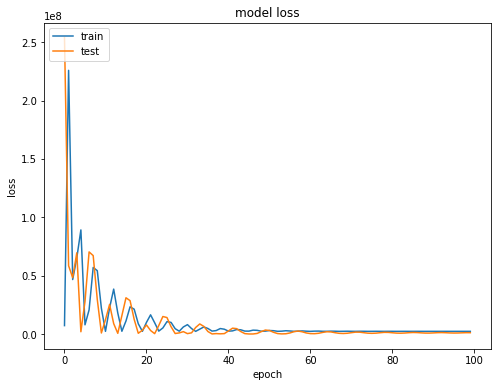

In [75]:
history = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, verbose=0)  #..., callbacks=[cp1], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [76]:
# from sklearn.metrics import mean_squared_error as mse

# def plot_predictions1(model, X, y, start=0, end=100):
#   predictions = model.predict(X).flatten()
#   df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
#   plt.plot(df['Predictions'])
#   plt.plot(df['Actuals'])
#   return df, mse(y, predictions)

In [77]:
# plot_predictions1(model1, X_test1, y_test1)

In [78]:
model2 = Sequential()
model2.add(InputLayer((3, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 1032      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


In [79]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

In [80]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, callbacks=[cp2])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 358993952.0000 - root_mean_squared_error: 18947.1348

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 1s 812ms/step - loss: 358993952.0000 - root_mean_squared_error: 18947.1348 - val_loss: 9440227615689408512.0000 - val_root_mean_squared_error: 3072495360.0000
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 7248173614590066688.0000 - root_mean_squared_error: 2692243200.0000 - val_loss: 692587194595078569984.0000 - val_root_mean_squared_error: 26317051904.0000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 531644025036576129024.0000 - root_mean_squared_error: 23057408000.0000

INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


1/1 [==============================] - 0s 438ms/step - loss: 531644025036576129024.0000 - root_mean_squared_error: 23057408000.0000 - val_loss: 583794304.0000 - val_root_mean_squared_error: 24161.8359
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 539428096.0000 - root_mean_squared_error: 23225.5918 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/100
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/100
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 7/100
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 8/100
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_er

In [81]:
model2 = load_model('model2/')
train_predictions2 = model2.predict(X_train1).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train1})
train_results2

1/1 [==============================] - 0s 42ms/step


,Train Predictions,Actuals
0,-4.453166,21453.0
1,-4.453166,21926.0
2,-4.453166,24945.0
3,-4.453166,24365.0


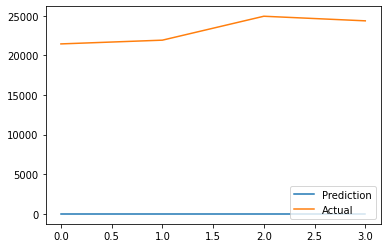

In [82]:
plt.plot(train_results2['Train Predictions'])
plt.plot(train_results2['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='lower right')

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


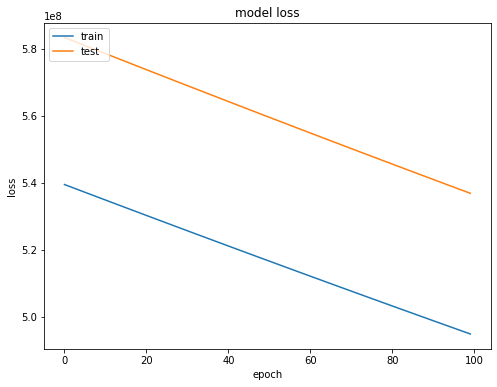

In [83]:
history = model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, verbose=0)  #..., callbacks=[cp2], verbose=0)
print(history.history.keys())

import matplotlib.pylab as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [84]:
val_predictions2 = model2.predict(X_val1).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val1})
val_results2

1/1 [==============================] - 0s 15ms/step


,Val Predictions,Actuals
0,988.15509,24293.0
1,988.15509,24021.0


In [85]:
test_predictions2 = model2.predict(X_test1).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test1})
test_results2

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,988.15509,23997.0


# MODEL 3

In [142]:
model3 = Sequential()
model3.add(InputLayer((3, 1)))
model3.add(GRU(64))
model3.add(Dense(50, 'relu'))
model3.add(Dense(50, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanAbsolutePercentageError(), optimizer=Adam(learning_rate=0.1), metrics=[RootMeanSquaredError()])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_18 (GRU)                (None, 64)                12864     
                                                                 
 dense_52 (Dense)            (None, 50)                3250      
                                                                 
 dense_53 (Dense)            (None, 50)                2550      
                                                                 
 dense_54 (Dense)            (None, 1)                 51        
                                                                 
Total params: 18,715
Trainable params: 18,715
Non-trainable params: 0
_________________________________________________________________


In [143]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=200, callbacks=[cp3])

Epoch 1/200
1/1 [==============================] - ETA: 0s - loss: 99.9999 - root_mean_squared_error: 23221.1289

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 99.9999 - root_mean_squared_error: 23221.1289 - val_loss: 99.9558 - val_root_mean_squared_error: 24146.7051
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 99.9742 - root_mean_squared_error: 23215.5195

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 99.9742 - root_mean_squared_error: 23215.5195 - val_loss: 99.7888 - val_root_mean_squared_error: 24106.3574
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 99.5438 - root_mean_squared_error: 23121.8105

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 99.5438 - root_mean_squared_error: 23121.8105 - val_loss: 99.5073 - val_root_mean_squared_error: 24038.3770
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 97.9818 - root_mean_squared_error: 22763.1895

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 97.9818 - root_mean_squared_error: 22763.1895 - val_loss: 98.6945 - val_root_mean_squared_error: 23842.0273
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 94.5706 - root_mean_squared_error: 21968.9336

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 94.5706 - root_mean_squared_error: 21968.9336 - val_loss: 97.8053 - val_root_mean_squared_error: 23627.2324
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 89.0448 - root_mean_squared_error: 20695.6973

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 89.0448 - root_mean_squared_error: 20695.6973 - val_loss: 96.4821 - val_root_mean_squared_error: 23307.6094
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 79.9681 - root_mean_squared_error: 18603.9570

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 79.9681 - root_mean_squared_error: 18603.9570 - val_loss: 94.1415 - val_root_mean_squared_error: 22742.2051
Epoch 8/200
1/1 [==============================] - ETA: 0s - loss: 66.4048 - root_mean_squared_error: 15482.5479

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 66.4048 - root_mean_squared_error: 15482.5479 - val_loss: 92.3714 - val_root_mean_squared_error: 22314.6230
Epoch 9/200
1/1 [==============================] - ETA: 0s - loss: 47.0056 - root_mean_squared_error: 11034.0889

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 47.0056 - root_mean_squared_error: 11034.0889 - val_loss: 86.4030 - val_root_mean_squared_error: 20872.9121
Epoch 10/200
1/1 [==============================] - ETA: 0s - loss: 20.6026 - root_mean_squared_error: 5070.9995

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 20.6026 - root_mean_squared_error: 5070.9995 - val_loss: 85.2405 - val_root_mean_squared_error: 20592.1250
Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 13.9811 - root_mean_squared_error: 3461.2439

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 13.9811 - root_mean_squared_error: 3461.2439 - val_loss: 82.2556 - val_root_mean_squared_error: 19871.0977
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 24.5392 - root_mean_squared_error: 5765.5430

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 24.5392 - root_mean_squared_error: 5765.5430 - val_loss: 74.0128 - val_root_mean_squared_error: 17879.9980
Epoch 13/200
1/1 [==============================] - ETA: 0s - loss: 21.4354 - root_mean_squared_error: 5069.0728

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 21.4354 - root_mean_squared_error: 5069.0728 - val_loss: 58.1691 - val_root_mean_squared_error: 14052.8926
Epoch 14/200
1/1 [==============================] - ETA: 0s - loss: 9.2367 - root_mean_squared_error: 2516.6292

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 9.2367 - root_mean_squared_error: 2516.6292 - val_loss: 58.0225 - val_root_mean_squared_error: 14017.4707
Epoch 15/200
1/1 [==============================] - 0s 23ms/step - loss: 7.8069 - root_mean_squared_error: 2412.6045 - val_loss: 60.2808 - val_root_mean_squared_error: 14562.9834
Epoch 16/200
1/1 [==============================] - 0s 24ms/step - loss: 14.9666 - root_mean_squared_error: 3851.4634 - val_loss: 61.3455 - val_root_mean_squared_error: 14820.1562
Epoch 17/200
1/1 [==============================] - 0s 24ms/step - loss: 15.5722 - root_mean_squared_error: 3980.9653 - val_loss: 59.1364 - val_root_mean_squared_error: 14286.5498
Epoch 18/200
1/1 [==============================] - ETA: 0s - loss: 10.8855 - root_mean_squared_error: 3005.3032

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 10.8855 - root_mean_squared_error: 3005.3032 - val_loss: 52.6192 - val_root_mean_squared_error: 12712.2998
Epoch 19/200
1/1 [==============================] - ETA: 0s - loss: 6.2515 - root_mean_squared_error: 1529.6351

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 6.2515 - root_mean_squared_error: 1529.6351 - val_loss: 44.9201 - val_root_mean_squared_error: 10852.6143
Epoch 20/200
1/1 [==============================] - ETA: 0s - loss: 7.9940 - root_mean_squared_error: 2288.3408

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 7.9940 - root_mean_squared_error: 2288.3408 - val_loss: 37.3969 - val_root_mean_squared_error: 9035.4668
Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 12.7016 - root_mean_squared_error: 3196.8445

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 12.7016 - root_mean_squared_error: 3196.8445 - val_loss: 32.5596 - val_root_mean_squared_error: 7867.1191
Epoch 22/200
1/1 [==============================] - 0s 23ms/step - loss: 9.8902 - root_mean_squared_error: 2637.9529 - val_loss: 37.7512 - val_root_mean_squared_error: 9121.0439
Epoch 23/200
1/1 [==============================] - 0s 22ms/step - loss: 6.3543 - root_mean_squared_error: 1489.9854 - val_loss: 39.5412 - val_root_mean_squared_error: 9553.3975
Epoch 24/200
1/1 [==============================] - 0s 25ms/step - loss: 6.7499 - root_mean_squared_error: 2193.3899 - val_loss: 34.4164 - val_root_mean_squared_error: 8315.5957
Epoch 25/200
1/1 [==============================] - ETA: 0s - loss: 10.9556 - root_mean_squared_error: 3010.8760

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 10.9556 - root_mean_squared_error: 3010.8760 - val_loss: 29.9378 - val_root_mean_squared_error: 7233.8818
Epoch 26/200
1/1 [==============================] - ETA: 0s - loss: 9.8579 - root_mean_squared_error: 2790.4126

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 9.8579 - root_mean_squared_error: 2790.4126 - val_loss: 25.5174 - val_root_mean_squared_error: 6166.3164
Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 5.9681 - root_mean_squared_error: 1772.1688

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 5.9681 - root_mean_squared_error: 1772.1688 - val_loss: 23.2107 - val_root_mean_squared_error: 5609.2524
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 6.2648 - root_mean_squared_error: 1473.3608

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 4s 4s/step - loss: 6.2648 - root_mean_squared_error: 1473.3608 - val_loss: 19.8070 - val_root_mean_squared_error: 4787.3208
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 6.8786 - root_mean_squared_error: 1940.9215

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 6.8786 - root_mean_squared_error: 1940.9215 - val_loss: 18.1469 - val_root_mean_squared_error: 4386.4780
Epoch 30/200
1/1 [==============================] - 0s 23ms/step - loss: 7.3570 - root_mean_squared_error: 2083.4197 - val_loss: 19.8803 - val_root_mean_squared_error: 4805.0146
Epoch 31/200
1/1 [==============================] - 0s 23ms/step - loss: 6.3169 - root_mean_squared_error: 1704.4786 - val_loss: 21.6761 - val_root_mean_squared_error: 5238.6680
Epoch 32/200
1/1 [==============================] - 0s 24ms/step - loss: 6.0969 - root_mean_squared_error: 1451.1733 - val_loss: 23.5203 - val_root_mean_squared_error: 5684.0059
Epoch 33/200
1/1 [==============================] - 0s 22ms/step - loss: 5.8583 - root_mean_squared_error: 1423.0500 - val_loss: 25.3991 - val_root_mean_squared_error: 6137.7412
Epoch 34/200
1/1 [==============================] - 0s 23ms/step - loss: 5.6023 - root_mean_squared_error: 1650.0005 - val_lo

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 5.5655 - root_mean_squared_error: 1552.1931 - val_loss: 15.7678 - val_root_mean_squared_error: 3812.1006
Epoch 39/200
1/1 [==============================] - 0s 22ms/step - loss: 8.5584 - root_mean_squared_error: 2248.7100 - val_loss: 17.6517 - val_root_mean_squared_error: 4266.9199
Epoch 40/200
1/1 [==============================] - 0s 23ms/step - loss: 6.1392 - root_mean_squared_error: 1712.5967 - val_loss: 21.7514 - val_root_mean_squared_error: 5256.8394
Epoch 41/200
1/1 [==============================] - 0s 23ms/step - loss: 4.7694 - root_mean_squared_error: 1145.2950 - val_loss: 25.5504 - val_root_mean_squared_error: 6174.2676
Epoch 42/200
1/1 [==============================] - 0s 23ms/step - loss: 5.5833 - root_mean_squared_error: 1749.2994 - val_loss: 24.8065 - val_root_mean_squared_error: 5994.6348
Epoch 43/200
1/1 [==============================] - 0s 23ms/step - loss: 5.0228 - root_mean_squared_error: 1587.8529 - val_lo

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 2s 2s/step - loss: 2.7482 - root_mean_squared_error: 729.7851 - val_loss: 15.4701 - val_root_mean_squared_error: 3740.2429
Epoch 53/200
1/1 [==============================] - 0s 24ms/step - loss: 3.2168 - root_mean_squared_error: 800.5683 - val_loss: 19.6638 - val_root_mean_squared_error: 4752.7549
Epoch 54/200
1/1 [==============================] - 0s 23ms/step - loss: 2.7371 - root_mean_squared_error: 724.4777 - val_loss: 18.8223 - val_root_mean_squared_error: 4549.5664
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 1.9997 - root_mean_squared_error: 554.0657

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 1.9997 - root_mean_squared_error: 554.0657 - val_loss: 13.4672 - val_root_mean_squared_error: 3256.7686
Epoch 56/200
1/1 [==============================] - ETA: 0s - loss: 4.7018 - root_mean_squared_error: 1110.4329

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 4.7018 - root_mean_squared_error: 1110.4329 - val_loss: 13.4354 - val_root_mean_squared_error: 3249.0977
Epoch 57/200
1/1 [==============================] - 0s 22ms/step - loss: 4.4310 - root_mean_squared_error: 1052.9720 - val_loss: 18.0709 - val_root_mean_squared_error: 4368.1235
Epoch 58/200
1/1 [==============================] - 0s 23ms/step - loss: 1.9188 - root_mean_squared_error: 513.4223 - val_loss: 17.7742 - val_root_mean_squared_error: 4296.4868
Epoch 59/200
1/1 [==============================] - ETA: 0s - loss: 1.7739 - root_mean_squared_error: 485.8320

INFO:tensorflow:Assets written to: model3/assets


INFO:tensorflow:Assets written to: model3/assets


1/1 [==============================] - 3s 3s/step - loss: 1.7739 - root_mean_squared_error: 485.8320 - val_loss: 13.1077 - val_root_mean_squared_error: 3170.0027
Epoch 60/200
1/1 [==============================] - 0s 22ms/step - loss: 4.1010 - root_mean_squared_error: 998.2823 - val_loss: 13.4767 - val_root_mean_squared_error: 3259.0596
Epoch 61/200
1/1 [==============================] - 0s 23ms/step - loss: 3.4145 - root_mean_squared_error: 855.4897 - val_loss: 25.0897 - val_root_mean_squared_error: 6063.0156
Epoch 62/200
1/1 [==============================] - 0s 24ms/step - loss: 2.9622 - root_mean_squared_error: 738.9396 - val_loss: 25.2157 - val_root_mean_squared_error: 6093.4556
Epoch 63/200
1/1 [==============================] - 0s 23ms/step - loss: 3.1561 - root_mean_squared_error: 783.8038 - val_loss: 21.4011 - val_root_mean_squared_error: 5172.2632
Epoch 64/200
1/1 [==============================] - 0s 25ms/step - loss: 2.0809 - root_mean_squared_error: 609.4705 - val_loss: 22

In [144]:
model3 = load_model('model3/')
train_predictions3 = model3.predict(X_train1).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train1})
train_results3

1/1 [==============================] - 0s 296ms/step


,Train Predictions,Actuals
0,22456.437500,21453.0
1,22528.859375,21926.0
2,25745.533203,24945.0
3,25770.376953,24365.0


(20000.0, 28000.0)

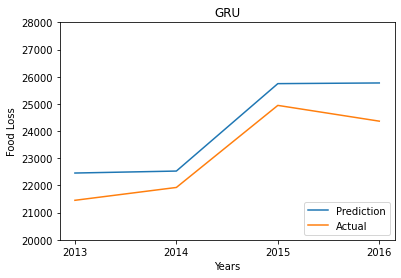

In [145]:
train_results3.index=['2013','2014','2015','2016']
plt.plot(train_results3['Train Predictions'])
plt.plot(train_results3['Actuals'])

plt.legend(['Prediction', 'Actual'], loc='lower right')
plt.ylim(20000,30000)
pyplot.xlabel("Years")
pyplot.ylabel("Food Loss")
plt.title("GRU")
plt.ylim(20000,28000)

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


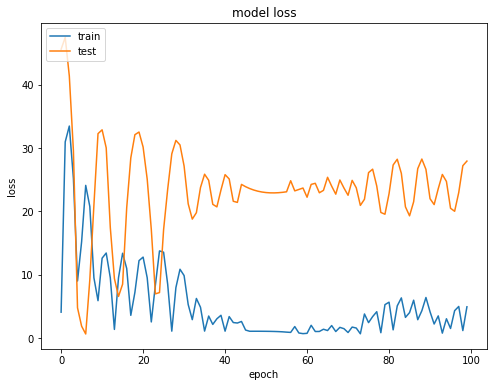

In [146]:
history = model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100, verbose=0)
print(history.history.keys())


figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [147]:
val_predictions3 = model3.predict(X_val1).flatten()
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val1})
val_results3

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,17401.720703,24293.0
1,17401.720703,24021.0


In [148]:
lstm_data

,Population,Actual Loss
Y2010,1399503000.0,19013.0
Y2011,1407325000.0,19976.0
Y2012,1415164000.0,21105.0
Y2013,1422971000.0,21453.0
Y2014,1430671000.0,21926.0
Y2015,1438193000.0,24945.0
Y2016,1445524000.0,24365.0
Y2017,1452626000.0,24293.0
Y2018,1459378000.0,24021.0
Y2019,1465634000.0,23997.0


In [152]:
lstm_data["Actual Loss"][6:]=tf.convert_to_tensor(lstm_data["Actual Loss"][6:], dtype=tf.int64)
test_predictions3 = model3.predict(lstm_data["Actual Loss"][6:]).flatten()
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test1})
test_results3

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [345]:
lstm_data["Actual Loss"][:3].values

array([19013, 19976, 21105])

In [444]:
X_test1

array([[[24365.],
        [24293.],
        [24021.]]])

In [449]:
# lstm_data["Actual Loss"][:3]=tf.convert_to_tensor(lstm_data["Actual Loss"][:3], dtype=tf.int64)
final_predictions=model3.predict([[[24159]]]).flatten()
final_result=pd.DataFrame(data={'Predictions':final_predictions, 'Actuals':[24159]})

1/1 [==============================] - 0s 56ms/step


In [450]:
final_result

,Predictions,Actuals
0,23180.673828,24159


In [339]:
final_result

,Predictions,Actuals
Y2010,23180.671875,19013
Y2011,23180.671875,19976
Y2012,23180.671875,21105
Y2013,23180.671875,21453
Y2014,23180.671875,21926
Y2015,23180.671875,24945
Y2016,23180.671875,24365
Y2017,23180.671875,24293
Y2018,23180.671875,24021
Y2019,23180.671875,23997


# Multi-variate Dataset

In [230]:
def df_to_X_y2(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [231]:
X2, y2 = df_to_X_y2(lstm_data)
X2.shape, y2.shape

((5, 5, 2), (5,))

In [232]:
# loss_training_mean = np.mean(X_train2[:, :, 1])
# loss_training_std = np.std(X_train2[:, :, 1])
                           
# def preprocess_loss(X):
#   X[:, :, 1] = (X[:, :, 1] - loss_training_mean) / loss_training_std
#   return X

# pop_training_mean = np.mean(X_train2[:, :, 0])
# pop_training_std = np.std(X_train2[:, :, 0])
                           
# def preprocess_pop(X):
#   X[:, :, 0] = (X[:, :, 0] - pop_training_mean) / pop_training_std
#   return X

loss_mean = np.mean(X2[:, :, 1])
loss_std = np.std(X2[:, :, 1])
                           
def preprocess_loss(X):
  X[:, :, 1] = (X[:, :, 1] - loss_mean) / loss_std
  return X

pop_mean = np.mean(X_train2[:, :, 0])
pop_std = np.std(X_train2[:, :, 0])
                           
def preprocess_pop(X):
  X[:, :, 0] = (X[:, :, 0] - pop_mean) / pop_std
  return X

In [233]:
# preprocess_loss(X_train2)
# preprocess_loss(X_val2)
# preprocess_loss(X_test2)
# preprocess_pop(X_train2)
# preprocess_pop(X_val2)
# preprocess_pop(X_test2)
X2=X2[:]
preprocess_loss(X2)
preprocess_pop(X2)

array([[[2212808536.1193137, -1.9669935250211181],
        [2225176204.048232, -1.4281233840900263],
        [2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703]],

       [[2225176204.048232, -1.4281233840900263],
        [2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284]],

       [[2237570751.337262, -0.7963638938395562],
        [2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284],
        [2285574126.218618, 1.0278486289385949]],

       [[2249914702.183729, -0.6016320049049559],
        [2262089471.175378, -0.33695331678407703],
        [2273982797.455271, 1.3524017771629284],
        [2285574126.218618, 1.0278486289385949],
        [2296803374.189876, 0.98755927260729

In [234]:
X_train2, y_train2 = X2[:3], y2[:3]
X_val2, y_val2 = X2[3:4], y2[3:4]
X_test2, y_test2 = X2[4:], y2[4:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((3, 5, 2), (3,), (1, 5, 2), (1,), (1, 5, 2), (1,))

In [235]:
X_train2=tf.convert_to_tensor(X_train2, dtype=tf.int64)
y_train2=tf.convert_to_tensor(y_train2, dtype=tf.int64)
X_val2=tf.convert_to_tensor(X_val2, dtype=tf.int64)
y_val2=tf.convert_to_tensor(y_val2, dtype=tf.int64)
X_test2=tf.convert_to_tensor(X_test2, dtype=tf.int64)
y_test2=tf.convert_to_tensor(y_test2, dtype=tf.int64)


# MODEL 4

In [534]:
model4 = Sequential()
model4.add(InputLayer((5, 2)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))
model4.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                17152     
                                                                 
 dense_76 (Dense)            (None, 8)                 520       
                                                                 
 dense_77 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,681
Trainable params: 17,681
Non-trainable params: 0
_________________________________________________________________


In [535]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=100), metrics=[RootMeanSquaredError()])

In [536]:
model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp4])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 10s 10s/step - loss: 2089353705190064128.0000 - root_mean_squared_error: 1445459712.0000 - val_loss: 2129490277650399232.0000 - val_root_mean_squared_error: 1459277312.0000
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 2089062609486610432.0000 - root_mean_squared_error: 1445358976.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2089062609486610432.0000 - root_mean_squared_error: 1445358976.0000 - val_loss: 2128890768935354368.0000 - val_root_mean_squared_error: 1459071872.0000
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 2088468598329704448.0000 - root_mean_squared_error: 1445153536.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2088468598329704448.0000 - root_mean_squared_error: 1445153536.0000 - val_loss: 2127823280583737344.0000 - val_root_mean_squared_error: 1458706048.0000
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 2087411417899597824.0000 - root_mean_squared_error: 1444787712.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2087411417899597824.0000 - root_mean_squared_error: 1444787712.0000 - val_loss: 2126259637610086400.0000 - val_root_mean_squared_error: 1458169984.0000
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 2085862755771875328.0000 - root_mean_squared_error: 1444251648.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2085862755771875328.0000 - root_mean_squared_error: 1444251648.0000 - val_loss: 2124173451735334912.0000 - val_root_mean_squared_error: 1457454464.0000
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 2083796635984330752.0000 - root_mean_squared_error: 1443536128.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2083796635984330752.0000 - root_mean_squared_error: 1443536128.0000 - val_loss: 2121538746997276672.0000 - val_root_mean_squared_error: 1456550272.0000
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 2081186945135804416.0000 - root_mean_squared_error: 1442631936.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2081186945135804416.0000 - root_mean_squared_error: 1442631936.0000 - val_loss: 2118329822311612416.0000 - val_root_mean_squared_error: 1455448320.0000
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 2078008669336764416.0000 - root_mean_squared_error: 1441529984.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2078008669336764416.0000 - root_mean_squared_error: 1441529984.0000 - val_loss: 2114520976594042880.0000 - val_root_mean_squared_error: 1454139264.0000
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 2074236382380818432.0000 - root_mean_squared_error: 1440220928.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2074236382380818432.0000 - root_mean_squared_error: 1440220928.0000 - val_loss: 2110088570344570880.0000 - val_root_mean_squared_error: 1452614400.0000
Epoch 10/20
1/1 [==============================] - ETA: 0s - loss: 2069846444767969280.0000 - root_mean_squared_error: 1438696064.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 5s 5s/step - loss: 2069846444767969280.0000 - root_mean_squared_error: 1438696064.0000 - val_loss: 2105007039917850624.0000 - val_root_mean_squared_error: 1450864256.0000
Epoch 11/20
1/1 [==============================] - ETA: 0s - loss: 2064813705169731584.0000 - root_mean_squared_error: 1436945920.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 5s 5s/step - loss: 2064813705169731584.0000 - root_mean_squared_error: 1436945920.0000 - val_loss: 2099253295569698816.0000 - val_root_mean_squared_error: 1448880000.0000
Epoch 12/20
1/1 [==============================] - ETA: 0s - loss: 2059115211280875520.0000 - root_mean_squared_error: 1434961792.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 5s 5s/step - loss: 2059115211280875520.0000 - root_mean_squared_error: 1434961792.0000 - val_loss: 2092803148044304384.0000 - val_root_mean_squared_error: 1446652416.0000
Epoch 13/20
1/1 [==============================] - ETA: 0s - loss: 2052727186162450432.0000 - root_mean_squared_error: 1432734208.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 5s 5s/step - loss: 2052727186162450432.0000 - root_mean_squared_error: 1432734208.0000 - val_loss: 2085635019425972224.0000 - val_root_mean_squared_error: 1444172800.0000
Epoch 14/20
1/1 [==============================] - ETA: 0s - loss: 2045628189337714688.0000 - root_mean_squared_error: 1430254592.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 4s 4s/step - loss: 2045628189337714688.0000 - root_mean_squared_error: 1430254592.0000 - val_loss: 2077725957409472512.0000 - val_root_mean_squared_error: 1441431936.0000
Epoch 15/20
1/1 [==============================] - ETA: 0s - loss: 2037795405940391936.0000 - root_mean_squared_error: 1427513728.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2037795405940391936.0000 - root_mean_squared_error: 1427513728.0000 - val_loss: 2069055621029691392.0000 - val_root_mean_squared_error: 1438421248.0000
Epoch 16/20
1/1 [==============================] - ETA: 0s - loss: 2029209044761182208.0000 - root_mean_squared_error: 1424503040.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2029209044761182208.0000 - root_mean_squared_error: 1424503040.0000 - val_loss: 2059603257004654592.0000 - val_root_mean_squared_error: 1435131776.0000
Epoch 17/20
1/1 [==============================] - ETA: 0s - loss: 2019848077640204288.0000 - root_mean_squared_error: 1421213568.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2019848077640204288.0000 - root_mean_squared_error: 1421213568.0000 - val_loss: 2049349898758782976.0000 - val_root_mean_squared_error: 1431555072.0000
Epoch 18/20
1/1 [==============================] - ETA: 0s - loss: 2009694500074553344.0000 - root_mean_squared_error: 1417636992.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 2009694500074553344.0000 - root_mean_squared_error: 1417636992.0000 - val_loss: 2038277129472311296.0000 - val_root_mean_squared_error: 1427682432.0000
Epoch 19/20
1/1 [==============================] - ETA: 0s - loss: 1998729620366557184.0000 - root_mean_squared_error: 1413764352.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1998729620366557184.0000 - root_mean_squared_error: 1413764352.0000 - val_loss: 2026368044153962496.0000 - val_root_mean_squared_error: 1423505536.0000
Epoch 20/20
1/1 [==============================] - ETA: 0s - loss: 1986936945841799168.0000 - root_mean_squared_error: 1409587456.0000

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


1/1 [==============================] - 3s 3s/step - loss: 1986936945841799168.0000 - root_mean_squared_error: 1409587456.0000 - val_loss: 2013606974763040768.0000 - val_root_mean_squared_error: 1419016192.0000


In [537]:
model4 = load_model('model4/')
train_predictions4 = model4.predict(X_train2).flatten()
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y_train2})
train_results4

1/1 [==============================] - 0s 394ms/step


,Train Predictions,Actuals
0,40361816.0,1438193000
1,40361816.0,1445524000
2,40361816.0,1452626000


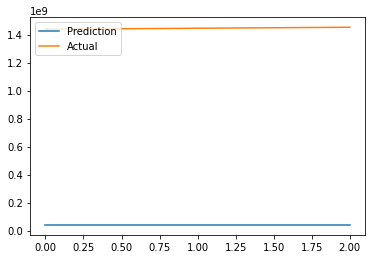

In [538]:
plt.plot(train_results4['Train Predictions'])
plt.plot(train_results4['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [539]:
history = model4.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, verbose=0)
print(history.history.keys())

figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets
Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fe27d92cf70>
Traceback (most recent call last):
  File "/Users/murathansaygili/Desktop/SIC/venv/lib/python3.9/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    def __del__(self):
KeyboardInterrupt: 


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


KeyboardInterrupt: 

In [242]:
val_predictions4 = model4.predict(X_val2).flatten()
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val2})
val_results4

1/1 [==============================] - 0s 16ms/step


,Val Predictions,Actuals
0,1.456134e+09,1459378000


In [243]:
test_predictions4 = model4.predict(X_test2).flatten()
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y_test2})
test_results4

1/1 [==============================] - 0s 16ms/step


,Test Predictions,Actuals
0,1.456134e+09,1465634000


# MODEL 5

In [244]:
model5 = Sequential()
model5.add(InputLayer((5, 2)))
model5.add(Conv1D(64, kernel_size=2))
model5.add(Flatten())
model5.add(Dense(8, 'relu'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 64)             320       
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 8)                 2056      
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [245]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=10), metrics=[RootMeanSquaredError()])

In [246]:
model5.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=20, callbacks=[cp5])

Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 2819886685431529472.0000 - root_mean_squared_error: 1679251840.0000

INFO:tensorflow:Assets written to: model5/assets


INFO:tensorflow:Assets written to: model5/assets


1/1 [==============================] - 1s 813ms/step - loss: 2819886685431529472.0000 - root_mean_squared_error: 1679251840.0000 - val_loss: 214065414147523215360.0000 - val_root_mean_squared_error: 14630974464.0000
Epoch 2/20
1/1 [==============================] - 0s 20ms/step - loss: 209719950680505974784.0000 - root_mean_squared_error: 14481711104.0000 - val_loss: 2469249366293391343616.0000 - val_root_mean_squared_error: 49691541504.0000
Epoch 3/20
1/1 [==============================] - 0s 21ms/step - loss: 2416633530371845128192.0000 - root_mean_squared_error: 49159266304.0000 - val_loss: nan - val_root_mean_squared_error: nan
Epoch 4/20
1/1 [==============================] - 0s 20ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 5/20
1/1 [==============================] - 0s 21ms/step - loss: nan - root_mean_squared_error: nan - val_loss: nan - val_root_mean_squared_error: nan
Epoch 6/20
1/1 [==============================

In [247]:
model5 = load_model('model5/')
train_predictions5 = model5.predict(X_train2).flatten()
train_results5 = pd.DataFrame(data={'Train Predictions':train_predictions5, 'Actuals':y_train2})
train_results5

1/1 [==============================] - 0s 43ms/step


,Train Predictions,Actuals
0,-1.296720e+10,1438193000
1,-1.303647e+10,1445524000
2,-1.310473e+10,1452626000


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


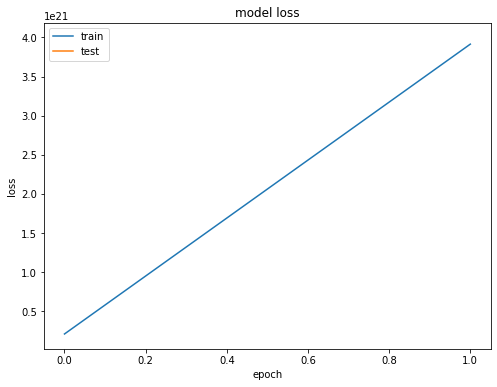

In [248]:
history = model5.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200, callbacks=[cp5], verbose=0)
print(history.history.keys())


figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# MODEL 6

In [249]:
model6 = Sequential()
model6.add(InputLayer((5, 2)))
model6.add(GRU(64))
model6.add(Dense(8, 'relu'))
model6.add(Dense(1, 'linear'))
model6.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                13056     
                                                                 
 dense_30 (Dense)            (None, 8)                 520       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,585
Trainable params: 13,585
Non-trainable params: 0
_________________________________________________________________


In [417]:
cp6 = ModelCheckpoint('model6/', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=100), metrics=[RootMeanSquaredError()])

In [418]:
model6.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=5000, callbacks=[cp6])

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 34721606139904.0000 - root_mean_squared_error: 5892504.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 2s 2s/step - loss: 34721606139904.0000 - root_mean_squared_error: 5892504.0000 - val_loss: 1027353291522048.0000 - val_root_mean_squared_error: 32052352.0000
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 2149132244353024.0000 - root_mean_squared_error: 46358736.0000

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 1s 867ms/step - loss: 2149132244353024.0000 - root_mean_squared_error: 46358736.0000 - val_loss: 4987253948416.0000 - val_root_mean_squared_error: 2233216.0000
Epoch 3/1000
1/1 [==============================] - 0s 24ms/step - loss: 171541966880768.0000 - root_mean_squared_error: 13097403.0000 - val_loss: 1207007679873024.0000 - val_root_mean_squared_error: 34742016.0000
Epoch 4/1000
1/1 [==============================] - 0s 23ms/step - loss: 467846324813824.0000 - root_mean_squared_error: 21629756.0000 - val_loss: 2367094989520896.0000 - val_root_mean_squared_error: 48652800.0000
Epoch 5/1000
1/1 [==============================] - 0s 24ms/step - loss: 1240368838344704.0000 - root_mean_squared_error: 35218872.0000 - val_loss: 2023450898071552.0000 - val_root_mean_squared_error: 44982784.0000
Epoch 6/1000
1/1 [==============================] - 0s 24ms/step - loss: 998974160896000.0000 - root_mean_squared_error: 31606552.0000 - val_loss: 10063817044

INFO:tensorflow:Assets written to: model6/assets


INFO:tensorflow:Assets written to: model6/assets


1/1 [==============================] - 1s 863ms/step - loss: 35433996091392.0000 - root_mean_squared_error: 5952646.0000 - val_loss: 266883825664.0000 - val_root_mean_squared_error: 516608.0000
Epoch 9/1000
1/1 [==============================] - 0s 24ms/step - loss: 243433025306624.0000 - root_mean_squared_error: 15602340.0000 - val_loss: 88886579560448.0000 - val_root_mean_squared_error: 9427968.0000
Epoch 10/1000
1/1 [==============================] - 0s 24ms/step - loss: 580327458209792.0000 - root_mean_squared_error: 24089986.0000 - val_loss: 103811641245696.0000 - val_root_mean_squared_error: 10188800.0000
Epoch 11/1000
1/1 [==============================] - 0s 25ms/step - loss: 616468198719488.0000 - root_mean_squared_error: 24828778.0000 - val_loss: 17264091856896.0000 - val_root_mean_squared_error: 4155008.0000
Epoch 12/1000
1/1 [==============================] - 0s 25ms/step - loss: 361797810913280.0000 - root_mean_squared_error: 19020984.0000 - val_loss: 35792940433408.0000 -

In [252]:
model6 = load_model('model6/')
train_predictions6 = model6.predict(X_train2).flatten()
train_results6 = pd.DataFrame(data={'Train Predictions':train_predictions6, 'Actuals':y_train2})
train_results6

1/1 [==============================] - 0s 293ms/step


,Train Predictions,Actuals
0,680454.9375,1438193000
1,680454.9375,1445524000
2,680454.9375,1452626000


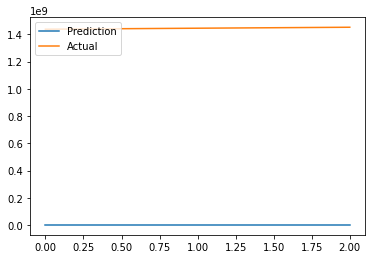

In [253]:
plt.plot(train_results6['Train Predictions'])
plt.plot(train_results6['Actuals'])
plt.legend(['Prediction', 'Actual'], loc='upper left')

In [254]:
val_predictions6 = model6.predict(X_val2).flatten()
val_results6 = pd.DataFrame(data={'Val Predictions':val_predictions6, 'Actuals':y_val2})
val_results6

1/1 [==============================] - 0s 15ms/step


,Val Predictions,Actuals
0,680455.0,1459378000


In [255]:
test_predictions6 = model6.predict(X_test2).flatten()
test_results6 = pd.DataFrame(data={'Test Predictions':test_predictions6, 'Actuals':y_test2})
test_results6

1/1 [==============================] - 0s 15ms/step


,Test Predictions,Actuals
0,680455.0,1465634000


dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


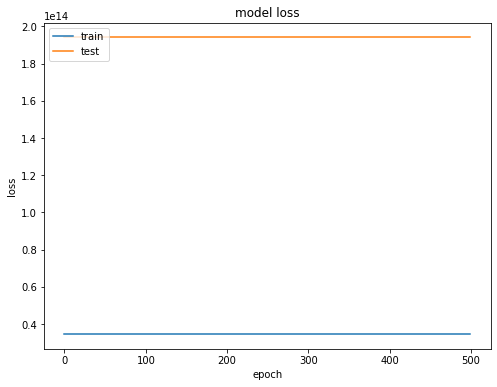

In [420]:
history = model6.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=500, verbose=0)
print(history.history.keys())


figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# -----------------------------

# -----------------------------

# -----------------------------

# -----------------------------

# -----------------------------

In [258]:
df = pd.read_csv("Data/Data.csv")
df = df[["country", "commodity", "year", "loss_percentage", "activity", "food_supply_stage", "cause_of_loss"]]

def focus_on(country, commodity):
    new_df = df[df.country == country]
    new_df = new_df[new_df.commodity == commodity]
    return new_df

# data = focus_on("Kenya", "Maize (corn)")
data = focus_on("Benin", "Maize (corn)")
data = data.reset_index()
data.sort_values(by=(["index"]), ascending=False, inplace=True)
data

,index,country,commodity,year,loss_percentage,activity,food_supply_stage,cause_of_loss
151,3072,Benin,Maize (corn),2000,6.42,"Drying, Harvesting",Harvest,NaN
150,3071,Benin,Maize (corn),2000,2.36,Transportation,Farm,NaN
149,3070,Benin,Maize (corn),2000,4.00,Drying,Farm,NaN
148,3069,Benin,Maize (corn),2000,3.05,Storage,Farm,NaN
147,3068,Benin,Maize (corn),2000,1.65,Transportation,Transport,NaN
...,...,...,...,...,...,...,...,...
4,2452,Benin,Maize (corn),2020,2.36,Transportation,Farm,NaN
3,2451,Benin,Maize (corn),2020,4.00,Drying,Farm,NaN
2,2450,Benin,Maize (corn),2020,6.42,"Drying, Harvesting",Harvest,NaN
1,2449,Benin,Maize (corn),2020,3.04,Storage,Farm,NaN


In [ ]:
validate = data[["activity","food_supply_stage","loss_percentage"]].tail(3)
data.drop(data.tail(3).index,inplace=True)

In [ ]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]])
Y_data = Y_scaler.fit_transform(data[['loss_percentage']])

In [ ]:
X_data

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [ ]:
hist_window = 8
horizon = 3
TRAIN_SPLIT = 120
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [ ]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0])

In [ ]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True),
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     # tf.keras.layers.Dense(30, activation='tanh'),
     # tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.15),
     tf.keras.layers.Dense(units=horizon),
    ])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

In [ ]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:

data_val

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
timeseries_evaluation_metrics_func(validate["loss_percentage"],pred_Inverse[0])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot( list(validate['loss_percentage']))
plt.plot( list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Loss Percentage")
plt.xlabel('Years (After 2000)')
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
data_val = X_scaler.fit_transform(data[["activity","food_supply_stage","loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [ ]:
validate["loss_percentage"]

In [ ]:
pred_Inverse[0]

TUNING

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam','sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
    lstm_model_opt = tf.keras.models.Sequential([
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                    input_shape=x_train.shape[-2:]),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
         tf.keras.layers.Dense(20, activation='tanh'),
         tf.keras.layers.Dropout(0.25),
         tf.keras.layers.Dense(units=horizon),
        ])
    lstm_model_opt.compile(optimizer=hparams[HP_OPTIMIZER], loss='mse')
    lstm_model_opt.summary()
    model_path = 'Bidirectional_LSTM_Multivariate_opt.h5'
    early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='min')
    checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
    callbacks=[early_stopings,checkpoint]
    history = lstm_model.fit(train_data,epochs=50,steps_per_epoch=100,validation_data=val_data,validation_steps=50,verbose=1,callbacks=callbacks)
    (validate["loss_percentage"], pred_Inverse[0])
    return history

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    history = train_test_model(hparams)
    accuracy=model.evaluate(x_test, y_test)
    tf.summary.scalar(METRIC_ACCURACY, step=1)

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()


In [ ]:
data_val = X_scaler.fit_transform(data[["activity", "food_supply_stage", "loss_percentage"]].tail(8))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')


timeseries_evaluation_metrics_func(validate["loss_percentage"], pred_Inverse[0])
plt.figure(figsize=(16, 9))
plt.plot(list(validate['loss_percentage']))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual', 'predicted'))
plt.show()